In [1]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd



In [2]:
df = pd.read_csv(r"D:\epita class notes\semester - 3\action learnign\project repository\Hate_speech_detection_using_data_augmentation\Hate_speech_detection_using_data_augmentation\data\cleaned_dataset\labeled_data_cleaned.csv")
df

,count,hate_speech,offensive_language,neither,corrected_tweet,class
0,3,0,0,3,as a woman you shouldn't complain about cleani...,2
1,3,0,3,0,boy date coldtyga own bad for coffin dat hoe i...,1
2,3,0,3,0,dawn you ever fuck a bitch and she start to cr...,1
3,3,0,2,1,she look like a granny,1
4,6,0,6,0,they shit you hear about me might be true or i...,1
...,...,...,...,...,...,...
995,3,0,3,0,munda out here sucking bitches howdhow,1
996,3,0,3,0,bitch if your they hobbit you need to let me k...,1
997,3,0,2,1,these folks so bad in just here to talk trash,1
998,6,0,6,0,brittany bitch a my dog man,1


In [3]:
texts = df['corrected_tweet'].values
labels = df['class'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [6]:
num_labels = len(set(labels))
num_labels

3

In [7]:
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='tf')

In [9]:
train_input_ids = train_encodings['input_ids']

In [10]:
test_input_ids = test_encodings['input_ids']

In [11]:
batch_size = 16
num_epochs = 3
train_steps = (len(X_train) // batch_size) * num_epochs



In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)


In [13]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_input_ids, 
    y_train, 
    validation_data=(test_input_ids, y_test),
    epochs=num_epochs,
    batch_size=batch_size
)

Epoch 1/3


50/50 [==============================] - 143s 2s/step - loss: 0.7037 - accuracy: 0.7588 - val_loss: 0.5745 - val_accuracy: 0.7550
Epoch 2/3
50/50 [==============================] - 107s 2s/step - loss: 0.4378 - accuracy: 0.8300 - val_loss: 0.3905 - val_accuracy: 0.8550
Epoch 3/3
50/50 [==============================] - 103s 2s/step - loss: 0.3526 - accuracy: 0.8838 - val_loss: 0.3641 - val_accuracy: 0.8800


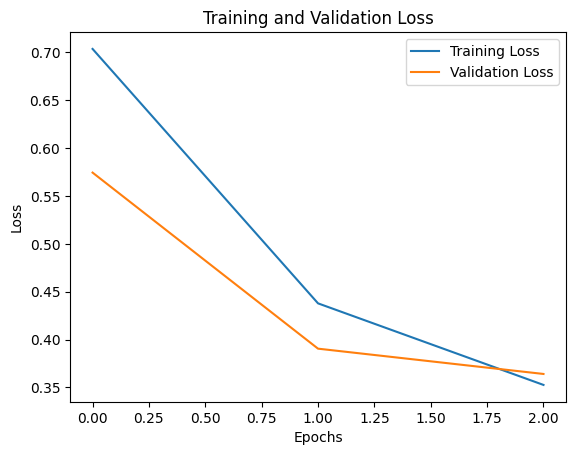

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()